# Calculate air-sea fluxes
This builds on `cm26_combine_filter_inputs.ipynb`


In [1]:
# !mamba install aerobulk-python -y

In [2]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [3]:
import json
import gcsfs
import xarray as xr
from aerobulk import noskin

import matplotlib.pyplot as plt
import numpy as np
import os
import dask
from scale_aware_air_sea.utils import to_zarr_split
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26

fs = gcsfs.GCSFileSystem()

# version = 'v0.5'
# suffix = ''
version = 'v0.6.1'
suffix = '_test'

# set up save targets
bucket = 'gs://leap-persistent/jbusecke'
smoothed_path = f"{bucket}/scale-aware-air-sea/smoothed/CM26_smoothed_{version}{suffix}.zarr"
smoothed_mapper = fs.get_mapper(smoothed_path)
output_path = f"{bucket}/scale-aware-air-sea/results/CM26_fluxes_{version}{suffix}.zarr"
output_mapper = fs.get_mapper(output_path)

In [4]:
ds = xr.open_dataset(
    smoothed_mapper,
    engine='zarr',
    chunks = {},
    consolidated=True,
    inline_array=True
)
ds

<xarray.Dataset>
Dimensions:                         (time: 3, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time                            (time) object 0181-01-01 12:00:00 ... 018...
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    q_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp_smoothed                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp_smoothed           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [5]:
ds_original = load_and_combine_cm26(fs, inline_array=True)
ds_original

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [6]:
ds = xr.merge([ds, ds_original], join='inner')
ds

<xarray.Dataset>
Dimensions:                         (time: 3, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time                            (time) object 0181-01-01 12:00:00 ... 018...
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables: (12/21)
    q_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp_smoothed                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp_smoothed           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                              ...
    wind                            (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean                         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean                         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [7]:
def compute_fluxes(
    ds,
    algo,
    method,
    sst_name = 'surface_temp',
    t_name = 't_ref',
    q_name = 'q_ref',
    u_name = 'u_relative',
    v_name = 'v_relative',
    slp_name = 'slp',
    skin_correction = False
):
    # input dependent on method
    if method == 'smooth_tracer':
        sst = ds[sst_name+'_smoothed']
        t = ds[t_name+'_smoothed']
        q = ds[q_name+'_smoothed']
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name+'_smoothed']
    elif method == 'smooth_vel':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_smoothed']
        v = ds[v_name+'_smoothed']
        slp = ds[slp_name]
    elif method == 'smooth_vel_tracer_atmos':
        sst = ds[sst_name]
        t = ds[t_name+'_smoothed']
        q = ds[q_name+'_smoothed']
        u = ds[u_name+'_smoothed_atmos_only']
        v = ds[v_name+'_smoothed_atmos_only']
        slp = ds[slp_name+'_smoothed']
    elif method == 'smooth_vel_tracer_ocean':
        sst = ds[sst_name+'_smoothed']
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_smoothed_ocean_only']
        v = ds[v_name+'_smoothed_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_vel_ocean':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_smoothed_ocean_only']
        v = ds[v_name+'_smoothed_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_all':
        sst = ds[sst_name+'_smoothed']
        t = ds[t_name+'_smoothed']
        q = ds[q_name+'_smoothed']
        u = ds[u_name+'_smoothed']
        v = ds[v_name+'_smoothed']
        slp = ds[slp_name+'_smoothed']
    elif method == 'smooth_none':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name]
    else:
        raise ValueError(f'`method`{method} not recognized')
        
    # if skin_correction:
    #     func = noskin
    
    ds_out = xr.Dataset()
    (
        ds_out['ql'],
        ds_out['qh'],
        ds_out['taux'],
        ds_out['tauy'],
        ds_out['evap']
    ) =  noskin(
        sst,
        t,
        q,
        u,
        v,
        slp=slp,
        algo=algo,
        zt=2,
        zu=10,
        input_range_check=False
    )
    return ds_out

In [8]:
datasets = []
for (algo, skin_correction) in [
    ('ncar', False), 
    ('ecmwf', False), 
    # ('coare3p0', False), 
    ('coare3p6', False), 
    # ('andreas', False)
]:
    algo_datasets = []
    for method in [
        'smooth_none', 'smooth_tracer',
        'smooth_vel', 'smooth_vel_ocean',
        'smooth_vel_tracer_ocean',
        'smooth_vel_tracer_atmos', 'smooth_all'
    ]:
        ds_method = compute_fluxes(ds, algo, method)
        ds_method = ds_method.assign_coords(smoothing=method)
        algo_datasets.append(ds_method)
    ds_algo = xr.concat(algo_datasets, dim='smoothing')
    ds_algo = ds_algo.assign_coords({'algo':f"{algo}{'_'+skin if skin_correction else ''}"})
    datasets.append(ds_algo)
ds_full = xr.concat(datasets, dim='algo')
ds_full

<xarray.Dataset>
Dimensions:    (time: 3, xt_ocean: 3600, yt_ocean: 2700, algo: 3, smoothing: 7)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0181-01-03 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * smoothing  (smoothing) <U23 'smooth_none' 'smooth_tracer' ... 'smooth_all'
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p6'
Data variables:
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    taux       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    tauy       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    evap       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

In [9]:
roi = dict(xt_ocean=slice(-85, -75), yt_ocean=slice(20,30))

In [10]:
test = ds_full.ql.isel(time=-1, algo=0).sel(smoothing='smooth_none').sel(**roi).load()

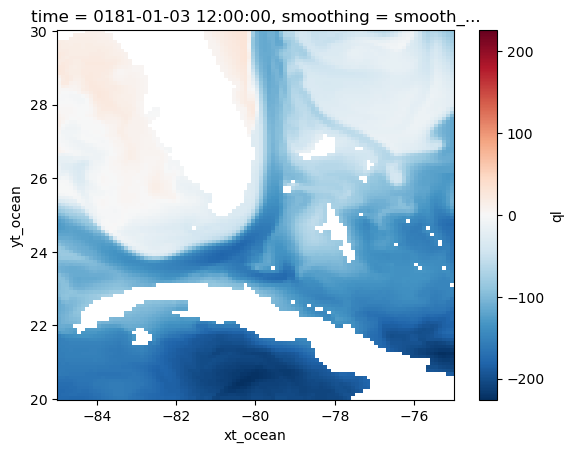

In [11]:
test.plot()

In [12]:
import subprocess
import logging
from distributed import WorkerPlugin

class MambaPlugin(WorkerPlugin):
    """
    Install packages on a worker as it starts up.

    Parameters
    ----------
    packages : List[str]
        A list of packages to install with pip on startup.
    """
    def __init__(self, packages):
        self.packages = packages

    def setup(self, worker):
        logger = logging.getLogger("distributed.worker")
        subprocess.call(['mamba', 'install'] + self.packages)
        logger.info("Installed %s", self.packages)

from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()
options.worker_memory = 52
# options.worker_cores = 6
options.worker_cores = 9 #10 would lead to some spilling)

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()

plugin = MambaPlugin(['aerobulk-python'])
client.register_worker_plugin(plugin)
# cluster.adapt(10, 200)
# cluster.scale(200)
cluster.scale(10)
client

[]


/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:1309: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+---------+
| Package | Client         | Scheduler      | Workers |
+---------+----------------+----------------+---------+
| python  | 3.9.15.final.0 | 3.9.13.final.0 | None    |
+---------+----------------+----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.6097481bad4d4ba280bf356c15996253/status,


In [13]:
ds_save = ds_full
if suffix == '_test':
    # only works on small subsets, otherwise see below.
    ds_save.to_zarr(output_mapper, mode='w')
else:
    # to_zarr_split(ds_save, output_mapper, split_interval=200)
    to_zarr_split(ds_save, output_mapper, split_interval=500)

In [14]:
xr.open_dataset(output_mapper, engine='zarr', chunks={}, consolidated=True)

<xarray.Dataset>
Dimensions:    (algo: 3, smoothing: 7, time: 3, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p6'
  * smoothing  (smoothing) <U23 'smooth_none' 'smooth_tracer' ... 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0181-01-03 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    evap       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    taux       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    tauy       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

In [15]:
print('hello')

hello


# Plots

In [16]:
ds_sample = xr.open_dataset(output_mapper, engine='zarr', chunks={}, consolidated=True)

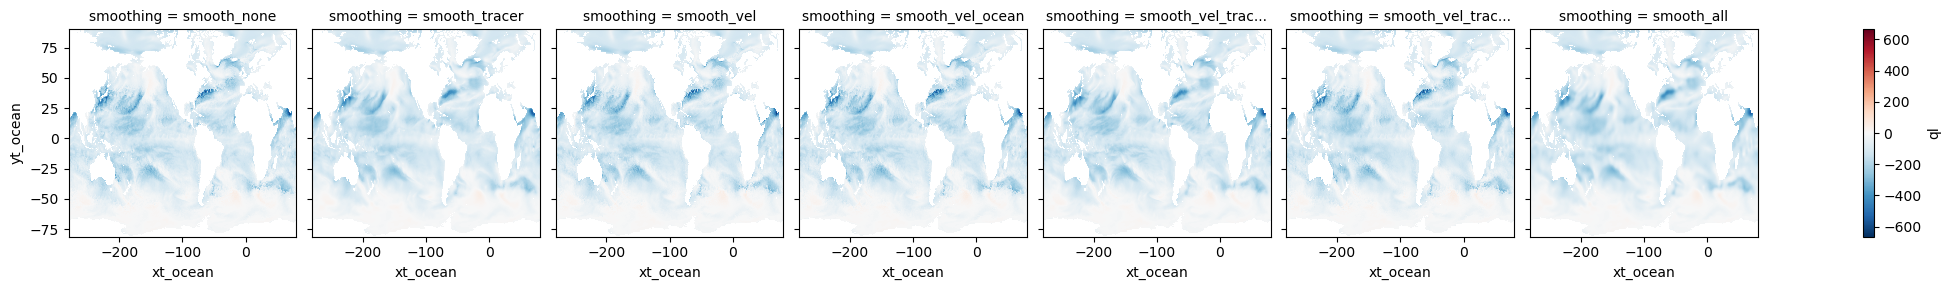

In [17]:
ds_sample['ql'].isel(algo=0, time=0).plot(col='smoothing')